# Optimizing the Overlap parameter `ov` for the Sliding Window Approach

To optimize the overlap parameter, there are two things we want to consider:

- keep `ov` possibly small to minimze the computation time T as $T \sim e^{\text{ov}}$
- chose `ov` which resulting gap distribution $\text{G}(\text{ov})$ is as close to $\text{G}(\text{1})$ as possible

For fullfill the second condition, we need some metric to compute the distance of two probability distribution. We want to use the _Kullback-Leibler divergence_ which is situated in the field of Information Theory for this purpose. <br>
As we are looking for one ideal value for all realistic cases of total time series length $n_{tot}$, we want to consider $\text{G}(\text{ov})$ as a 2 dimensional probability distribution with variables $(n_{tot}, \text{ix})$, which describe the total time series length and the gap index respectively.

## Kullback–Leibler divergence

General definition (Wikipedia): <br>
$D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\,\log {\frac {P(x)}{Q(x)}}$

We implemented a 2D version of this below.

In [3]:
import numpy as np

def kl_divergence_2d(P, Q):
    """
    Compute the Kullback-Leibler divergence D_KL(P || Q)
    between two 2D discrete probability distributions.

    Parameters
    ----------
    P, Q : 2D numpy arrays
        Must be nonnegative and sum to 1.

    Returns
    -------
    float
        The KL divergence D_KL(P || Q)
    """
    # Convert to float arrays
    P = np.array(P, dtype=float)
    Q = np.array(Q, dtype=float)

    # Check normalization
    if not np.isclose(P.sum(), 1.0):
        raise ValueError("P must sum to 1")
    if not np.isclose(Q.sum(), 1.0):
        raise ValueError("Q must sum to 1")

    # Avoid division by zero or log(0)
    mask = (P > 0) & (Q > 0)
    return np.sum(P[mask] * np.log(P[mask] / Q[mask]))

# Example usage:
if __name__ == "__main__":
    # Two example 2D distributions
    P = np.array([[0.1, 0.4],
                  [0.2, 0.3]])

    Q = np.array([[0.2, 0.3],
                  [0.1, 0.4]])

    print("D_KL(P || Q) =", kl_divergence_2d(P, Q))


D_KL(P || Q) = 0.09808292530117264


## Optimal Distribution $\text{G}(\text{1})$

In [9]:
import toad 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

from toad.shifts.methods.asswdetect import ASSWDETECT as ASSWDETECT

def make_hist(
        Tmin,
        Tmax,
        method,
        ):
    # proved some space
    hist = np.full((Tmax,Tmax+1), -1)
    for T in range(Tmin,Tmax+1):
        # SIGNAL GENERATION ============================================================
        time = np.linspace(0,T, T)
        signal = np.zeros(T)
        # APPLY DETECTOR METHOD ========================================================
        detector = method
        counter = detector.fit_predict(
            signal,
            time,
            return_gap=True,
            )
        # STORE RESULTS ================================================================
        counter[0] = 0
        counter[-1] = 0
        hist[:T,T] = counter

    return hist

def plot_hist(
        hist,
        ax,
        title,
        ):
    
    color_res = 4*256
    cmap_reds = matplotlib.colormaps['Reds']
    newcolors = cmap_reds(np.linspace(0, 1, color_res))
    grey = np.array([0.7, 0.7, 0.7, 1])
    ix = color_res//(hist.max()+1)
    newcolors = np.copy(newcolors)
    newcolors[:ix, :] = grey
    cmap_custom = ListedColormap(newcolors)
    
    im = ax.imshow(
        hist,
        aspect='auto',
        cmap=cmap_custom,
        origin='lower',
        )
    
    ax.set_xlabel('Time Series Length T', fontsize=14)
    ax.set_ylabel('Gap Index', fontsize=14)
    ax.set_title(title, fontsize=20)
    ax2 = ax.twinx()
    mid_idx = hist.shape[0] // 2
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks([mid_idx])
    ax2.set_yticklabels([''])
    ax2.tick_params(axis='y', labelsize=14)
    cbar = plt.colorbar(im, ax=ax2, orientation='vertical', fraction=0.025, pad=0.02)
    cbar.set_label('Number of Times Gap\nis Start or End of Segment', fontsize=14)
    cbar.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

In [5]:
Tmin = 50
Tmax = 1000
ov = 1

hist = make_hist(Tmin, Tmax, ASSWDETECT(overlap=ov))

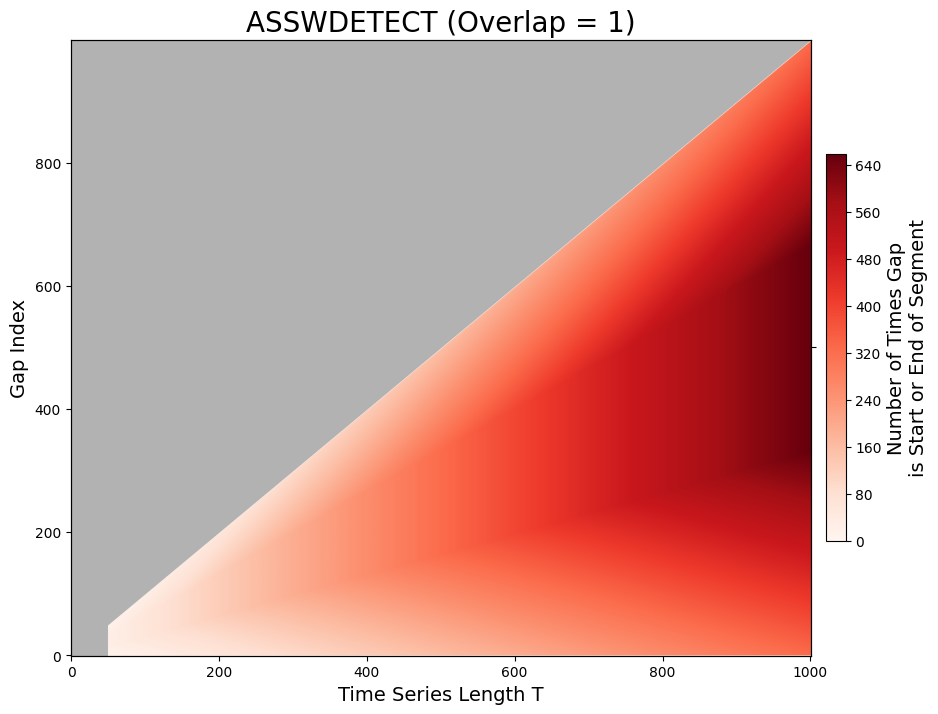

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
plot_hist(hist, axes, 'ASSWDETECT (Overlap = {})'.format(ov))

## Computing the Distance

In [38]:
import numpy as np

# import asswdetect_ov1_hist.csv
G1 = np.loadtxt('asswdetect_ov1_hist.csv', delimiter=',')
#print(G1.shape)
# replace -1 values with 0 value
G1[G1==-1.] = 0
# normalize to get probability distribution
G1 = G1/np.sum(G1)

In [ ]:
# get distribution
Tmin = 50
Tmax = 1000
ov = 0

G = make_hist(Tmin,Tmax,ASSWDETECT(overlap=ov))
G[G==-1.] = 0
G = G/np.sum(G)

In [40]:
# compute distance
print("D_KL(G || G1) =", kl_divergence_2d(G, G1))

D_KL(G || G1) = 0.21576877834294014


In [48]:
G1_small = make_hist(50,100,ASSWDETECT(overlap=1))
G1_small[G1_small==-1.] = 0
G1_small = G1_small/np.sum(G1_small)

In [77]:
# get distribution
Tmin = 50
Tmax = 1000
ov_arr = np.arange(0.0,0.505,0.005)
print(f"{ov_arr=}")

# get distances
distance_arr = np.zeros(len(ov_arr))
for i, ov in enumerate(ov_arr):
    print(f"Computing for overlap={ov:.3f}...",end='\r')
    G = make_hist(Tmin,Tmax,ASSWDETECT(overlap=ov))
    G[G==-1.] = 0
    G = G/np.sum(G)
    distance_arr[i] = kl_divergence_2d(G, G1)

ov_arr=array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  ])


In [ ]:
print("Distances:", distance_arr)
# save results
np.savetxt('data_time/ov_optimization_results.csv', np.vstack((ov_arr, distance_arr)).T, delimiter=',')
print("Results saved to 'ov_optimization_results.csv'.")

Distances: [0.21576878 0.21448967 0.21680199 0.21388987 0.20533668 0.19727796
 0.18814497 0.18191689 0.17615318 0.16648889 0.16243917 0.15696009
 0.15259573 0.14684175 0.14357594 0.13963118 0.1367332  0.13746495
 0.13240443 0.13154549 0.12966301 0.1282223  0.12458408 0.12714758
 0.12131281 0.12408787 0.12408956 0.11856908 0.11881633 0.12000714
 0.12034768 0.11545556 0.11628682 0.11647271 0.11742875 0.11651867
 0.11504894 0.11138825 0.1114919  0.11266692 0.11104286 0.10836334
 0.10814292 0.10803412 0.10933861 0.10667338 0.10718856 0.10753655
 0.10800179 0.10970826 0.10812351 0.1053764  0.10386863 0.10573937
 0.10733224 0.1060529  0.10839596 0.10997981 0.10445739 0.10436875
 0.10562676 0.10376255 0.1065298  0.10830059 0.10930447 0.11264734
 0.11870562 0.10852595 0.09939948 0.09729934 0.09779335 0.0964028
 0.09486154 0.09432727 0.0930586  0.09280497 0.09316359 0.09352664
 0.09351415 0.09436467 0.09024049 0.0869246  0.08809977 0.08835004
 0.08780002 0.08995083 0.08879716 0.08784119 0.08944

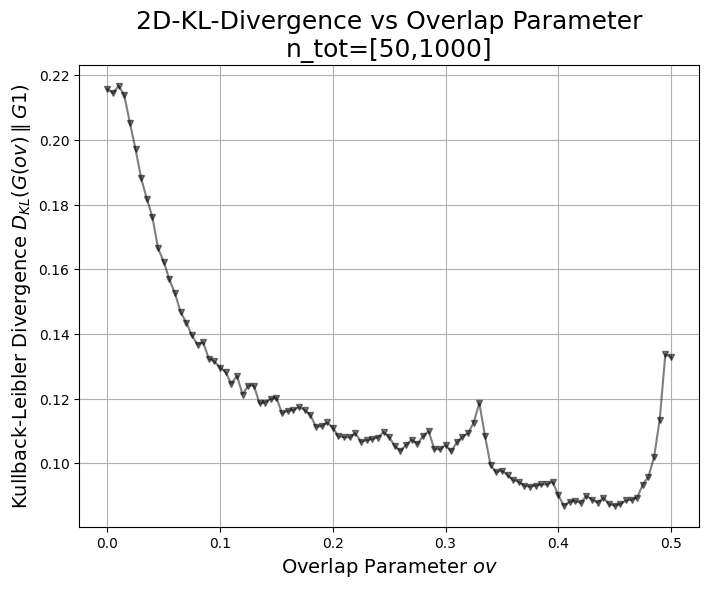

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(ov_arr, distance_arr, marker='v', markersize=4, color='black', lw=1.5, alpha=0.5)
plt.xlabel(r'Overlap Parameter $ov$', fontsize=14)
plt.ylabel(r'Kullback-Leibler Divergence $D_{KL}(G(ov) \parallel G1)$', fontsize=14)
plt.title('2D-KL-Divergence vs Overlap Parameter\nn_tot=[50,1000]', fontsize=18)
plt.grid()
plt.show()

In [81]:
import numpy as np

def refine_kl_grid(Tmin, Tmax, ov_arr, distance_arr, make_hist, ASSWDETECT, kl_divergence_2d, G1,
                   new_step=0.001, recompute_missing=True):
    """
    Reuse existing KL results and compute only missing overlap points for finer resolution.
    
    Parameters
    ----------
    Tmin, Tmax : float
        Temperature range parameters for make_hist().
    ov_arr : np.ndarray
        Existing overlap values.
    distance_arr : np.ndarray
        Existing KL-distance values.
    make_hist : callable
        Function to generate histogram (signature: make_hist(Tmin, Tmax, detector)).
    ASSWDETECT : callable
        Detector constructor (signature: ASSWDETECT(overlap=ov)).
    kl_divergence_2d : callable
        KL divergence function (signature: kl_divergence_2d(G, G1)).
    G1 : np.ndarray
        Reference distribution for KL computation.
    new_step : float, optional
        Desired finer step for overlap values.
    recompute_missing : bool, optional
        Whether to compute missing overlaps (default True).
    
    Returns
    -------
    ov_new : np.ndarray
        Sorted array of all overlap values (old + new).
    dist_new : np.ndarray
        Corresponding KL distances.
    """

    # Construct finer overlap grid
    ov_fine = np.arange(ov_arr.min(), ov_arr.max() + new_step/2, new_step)

    # Copy results to dictionary for quick lookup
    results_dict = {round(float(ov), 6): float(dist) for ov, dist in zip(ov_arr, distance_arr)}

    # Loop over all fine-grid points
    for ov in ov_fine:
        key = round(float(ov), 6)
        if key not in results_dict and recompute_missing:
            print(f"Computing missing value for overlap={ov:.3f} ...", end="\r")
            G = make_hist(Tmin, Tmax, ASSWDETECT(overlap=ov))
            G[G == -1.] = 0
            G = G / np.sum(G)
            results_dict[key] = kl_divergence_2d(G, G1)

    print("\nAll missing overlaps computed.")

    # Sort results by overlap
    ov_new = np.array(sorted(results_dict.keys()))
    dist_new = np.array([results_dict[k] for k in ov_new])

    return ov_new, dist_new


In [82]:
# Reuse your previous arrays and functions
ov_refined, dist_refined = refine_kl_grid(
    Tmin=50,
    Tmax=1000,
    ov_arr=ov_arr,
    distance_arr=distance_arr,
    make_hist=make_hist,
    ASSWDETECT=ASSWDETECT,
    kl_divergence_2d=kl_divergence_2d,
    G1=G1,
    new_step=0.001
)


Computing missing value for overlap=0.499 ...
All missing overlaps computed.


In [83]:
distance_arr = dist_refined
ov_arr = ov_refined

print(f"Refined to {len(ov_arr)} overlap points.")
print("Distances:", distance_arr)

Refined to 501 overlap points.
Distances: [0.21576878 0.21576878 0.21576878 0.21576878 0.2149537  0.21448967
 0.21411656 0.21466223 0.21557275 0.21592784 0.21680199 0.2176089
 0.21661852 0.21623288 0.21412492 0.21388987 0.21112429 0.20987048
 0.20915708 0.20743165 0.20533668 0.20285817 0.20161195 0.19925379
 0.19778556 0.19727796 0.19438193 0.19201635 0.1934928  0.18913968
 0.18814497 0.18657311 0.18442759 0.18405767 0.18134711 0.18191689
 0.1813526  0.17741553 0.17569409 0.17551529 0.17615318 0.1725766
 0.17146727 0.16920676 0.1707238  0.16648889 0.16831903 0.16429985
 0.16627904 0.16218455 0.16243917 0.16047743 0.15810377 0.16067512
 0.15990212 0.15696009 0.15615192 0.15499963 0.15270373 0.15383935
 0.15259573 0.14989721 0.14999661 0.15200972 0.14993818 0.14684175
 0.1464655  0.1471952  0.1474629  0.14408143 0.14357594 0.14296706
 0.143931   0.14365123 0.14156159 0.13963118 0.13939442 0.14114493
 0.14177037 0.13992479 0.1367332  0.13689407 0.13466889 0.13446871
 0.13718386 0.13746495

In [84]:
# save results
fp = 'data_time/ov_optimization_results_new.csv'
np.savetxt(fp, np.vstack((ov_arr, distance_arr)).T, delimiter=',')
print(f"Results saved to '{fp}'.")

Results saved to 'data_time/ov_optimization_results_new.csv'.


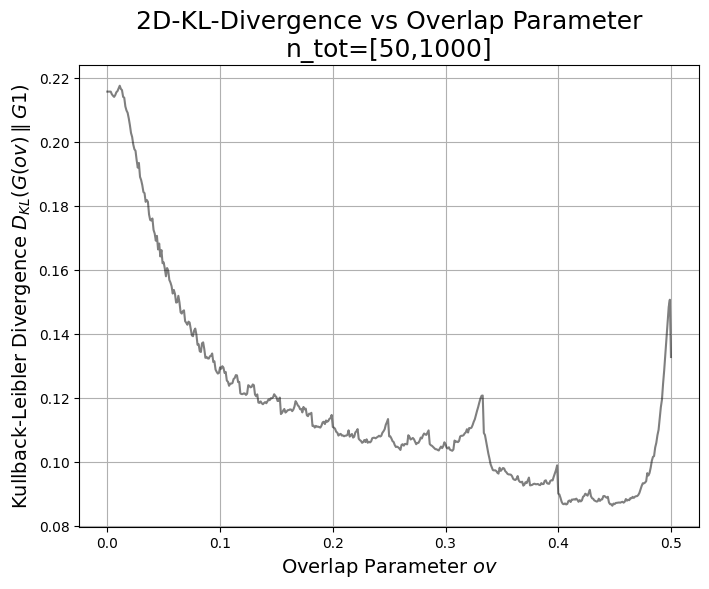

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(ov_arr, distance_arr, marker='v', markersize=0, color='black', lw=1.5, alpha=0.5)
plt.xlabel(r'Overlap Parameter $ov$', fontsize=14)
plt.ylabel(r'Kullback-Leibler Divergence $D_{KL}(G(ov) \parallel G1)$', fontsize=14)
plt.title('2D-KL-Divergence vs Overlap Parameter\nn_tot=[50,1000]', fontsize=18)
plt.grid()
plt.show()

## Get Time Data

In [88]:
import numpy as np
import pandas as pd

# import csv-file
fp = "data_time/sw_time_05.csv"
data = pd.read_csv(fp)

# display first rows
data.head()

,method,run,overlap,time
0,ASDETECT,1,NaN,122.775327
1,ASDETECT,2,NaN,122.468312
2,ASDETECT,3,NaN,122.576857
3,ASDETECT,4,NaN,122.469124
4,ASDETECT,5,NaN,122.637876


In [89]:
# group data by 'method' and 'overlap', include 'NaN' as a overlap-value
grouped = data.groupby(['method', 'overlap'], dropna=False)
# calculate mean and std for each group
summary = grouped.agg({'time': ['mean', 'std']}).reset_index()
# flatten MultiIndex columns
summary.columns = ['method', 'overlap', 'mean_time', 'std_time']
# display the summary
display(summary)

overlaps = summary['overlap'].unique()[1:]
ASDETECT_time = summary.loc[summary['method'] == 'ASDETECT', 'mean_time'].values[0]
ASSWDETECT_time = summary[summary['method'] == 'ASSWDETECT']['mean_time'].values
ASSWDETECT_std = summary[summary['method'] == 'ASSWDETECT']['std_time'].values
ASSWDETECT_DOUBLE_time = summary[summary['method'] == 'ASSWDETECT_DOUBLE']['mean_time'].values
ASSWDETECT_DOUBLE_std = summary[summary['method'] == 'ASSWDETECT_DOUBLE']['std_time'].values

,method,overlap,mean_time,std_time
0,ASDETECT,NaN,122.611618,0.113190
1,ASSWDETECT,0.0,125.093550,0.147898
2,ASSWDETECT,0.1,133.024432,0.104356
3,ASSWDETECT,0.2,149.202833,0.201474
4,ASSWDETECT,0.3,166.940558,0.187722
5,ASSWDETECT,0.4,192.712248,0.165946
6,ASSWDETECT,0.5,229.888426,0.110223
7,ASSWDETECT,0.6,278.794005,0.105646
8,ASSWDETECT,0.7,355.982197,0.225188
9,ASSWDETECT,0.8,520.421291,0.321444


In [100]:
print(ASSWDETECT_time)
time_factor = ASSWDETECT_time / ASDETECT_time
print(time_factor)

# fit exponential function to time data
from scipy.optimize import curve_fit

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Fit the model to the data
popt, pcov = curve_fit(exp_func, overlaps[:6], time_factor[:6], p0=(1, 1, 1))

# Print the optimal parameters
print("Optimal parameters for ASSWDETECT:", popt)

[125.09355046 133.02443222 149.20283339 166.94055781 192.71224791
 229.88842585 278.79400515 355.98219721 520.42129057 936.87932284]
[1.02024223 1.08492518 1.21687353 1.36153947 1.5717291  1.87493183
 2.27379761 2.90333169 4.24446963 7.64103219]
Optimal parameters for ASSWDETECT: [0.20436111 3.29520623 0.81207418]


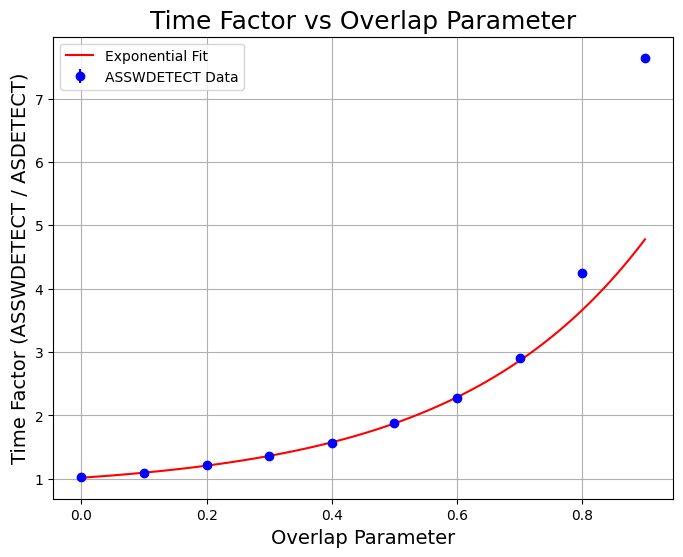

In [101]:
# print data and fit results
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.errorbar(overlaps, time_factor, yerr=ASSWDETECT_std/ASDETECT_time, fmt='o', label='ASSWDETECT Data', color='blue')
x_fit = np.linspace(overlaps.min(), overlaps.max(), 100)
y_fit = exp_func(x_fit, *popt)
plt.plot(x_fit, y_fit, label='Exponential Fit', color='red')
plt.xlabel('Overlap Parameter', fontsize=14)
plt.ylabel('Time Factor (ASSWDETECT / ASDETECT)', fontsize=14)
plt.title('Time Factor vs Overlap Parameter', fontsize=18)
plt.legend()
plt.grid()
plt.show()

## Combined Plot

In [213]:
# load KL distance results
fp = 'data_time/KLdiv_vals_ov-0o0-0o5.csv'
data = pd.read_csv(fp, delimiter=',', names=['overlap', 'KL_distance'])
ov_arr = data['overlap'].values
distance_arr = data['KL_distance'].values

In [214]:
ov_empirical = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
time_factor_empirical = [1.02024223, 1.08492518, 1.21687353, 1.36153947, 1.5717291, 1.87493183, 2.27379761, 2.90333169, 4.24446963, 7.64103219]

# define time-factor fit
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

popt = [0.20436111, 3.29520623, 0.81207418]

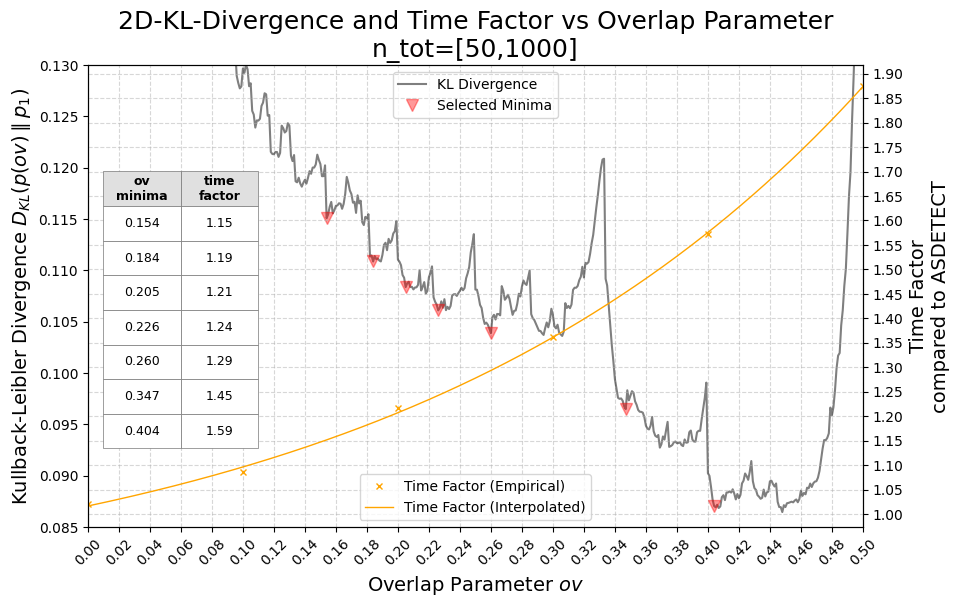

In [217]:
low_markers_ix = [154,184,205,226,260,347,404]


# make combined plot
# - plot KL divergence on left y-axis
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(ov_arr, distance_arr, marker='v', markersize=0, color='black', lw=1.5, alpha=0.5, label='KL Divergence')
# - plot markers for local minima
ax1.plot(
    ov_arr[low_markers_ix],
    distance_arr[low_markers_ix],
    marker='v',
    markersize=8,
    color='red',
    lw=0,
    label='Selected Minima',
    alpha=0.4)
# - customize x-ticks
xt = np.arange(0, 0.55, 0.02)
ax1.set_xticks(xt)
ax1.set_xticklabels([f"{x:.2f}" for x in xt], rotation=45, ha='center')
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0.085, 0.13)
ax1.set_xlabel(r'Overlap Parameter $ov$', fontsize=14)
ax1.set_ylabel(r'Kullback-Leibler Divergence $D_{KL}(p(ov) \parallel p_1)$', fontsize=14)
ax1.set_title('2D-KL-Divergence and Time Factor vs Overlap Parameter\nn_tot=[50,1000]', fontsize=18)
ax1.legend(loc='upper center')

# plot time factor on right y-axis
ax2 = ax1.twinx()
ax2.plot(ov_empirical[:6], time_factor_empirical[:6], marker='x', markersize=4, color='orange', lw=0, label='Time Factor (Empirical)')
time_factor_fit = exp_func(ov_arr, *popt)
ax2.plot(ov_arr, time_factor_fit, color='orange', lw=1, label='Time Factor (Interpolated)')
ax2.set_yticks(np.arange(1, max(time_factor_fit)+0.05, 0.05))
ax2.set_ylabel('Time Factor\ncompared to ASDETECT', fontsize=14)
ax2.legend(loc='lower center')
#plt.grid()
ax1.grid(axis='x', which='major', linestyle='--', alpha=0.5)
ax2.grid(axis='y', which='major', linestyle='--', alpha=0.5)

# create a small two-column table at the left side showing selected (ov, D_KL) values
table_rows = [[f"{ov_arr[i]:.3f}", f"{time_factor_fit[i]:.2f}"] for i in low_markers_ix]
col_labels = ["ov\nminima", "time\nfactor"]

tbl = ax2.table(
    cellText=table_rows,
    colLabels=col_labels,
    cellLoc="center",
    colLoc="center",
    bbox=[0.02, 0.17, 0.2, 0.6]  # [x0, y0, width, height] in axes coordinates (left side)
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.05)

# header styling
for j in range(len(col_labels)):
    tbl[(0, j)].set_facecolor("#e0e0e0")
    tbl[(0, j)].set_text_props(weight="bold")

# subtle cell borders
for key, cell in tbl.get_celld().items():
    cell.set_edgecolor("#777777")

    # ensure grid is drawn below artists and bring the table to the front
    ax1.set_axisbelow(True)
    ax2.set_axisbelow(True)

    # raise z-order for the whole table and its cells/texts so it sits on top of the grid
    tbl.set_zorder(100)
    for cell in tbl.get_celld().values():
        cell.set_zorder(100)
        cell.set_clip_on(False)        # avoid clipping by axes
        cell.set_edgecolor("#777777")
        cell.set_linewidth(0.5)
        # ensure text in cell is also above the grid
        txt = cell.get_text()
        if txt is not None:
            txt.set_zorder(101)
            txt.set_clip_on(False)

plt.savefig('data_time/ASSWDETECT/ov_optimization_combined_plot.png', dpi=200)
plt.show()

## Time Series Plots

overlap=array([0.154, 0.184, 0.205, 0.226, 0.26 , 0.347, 0.404, 1.   ])


/tmp/ipykernel_9514/3987805371.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


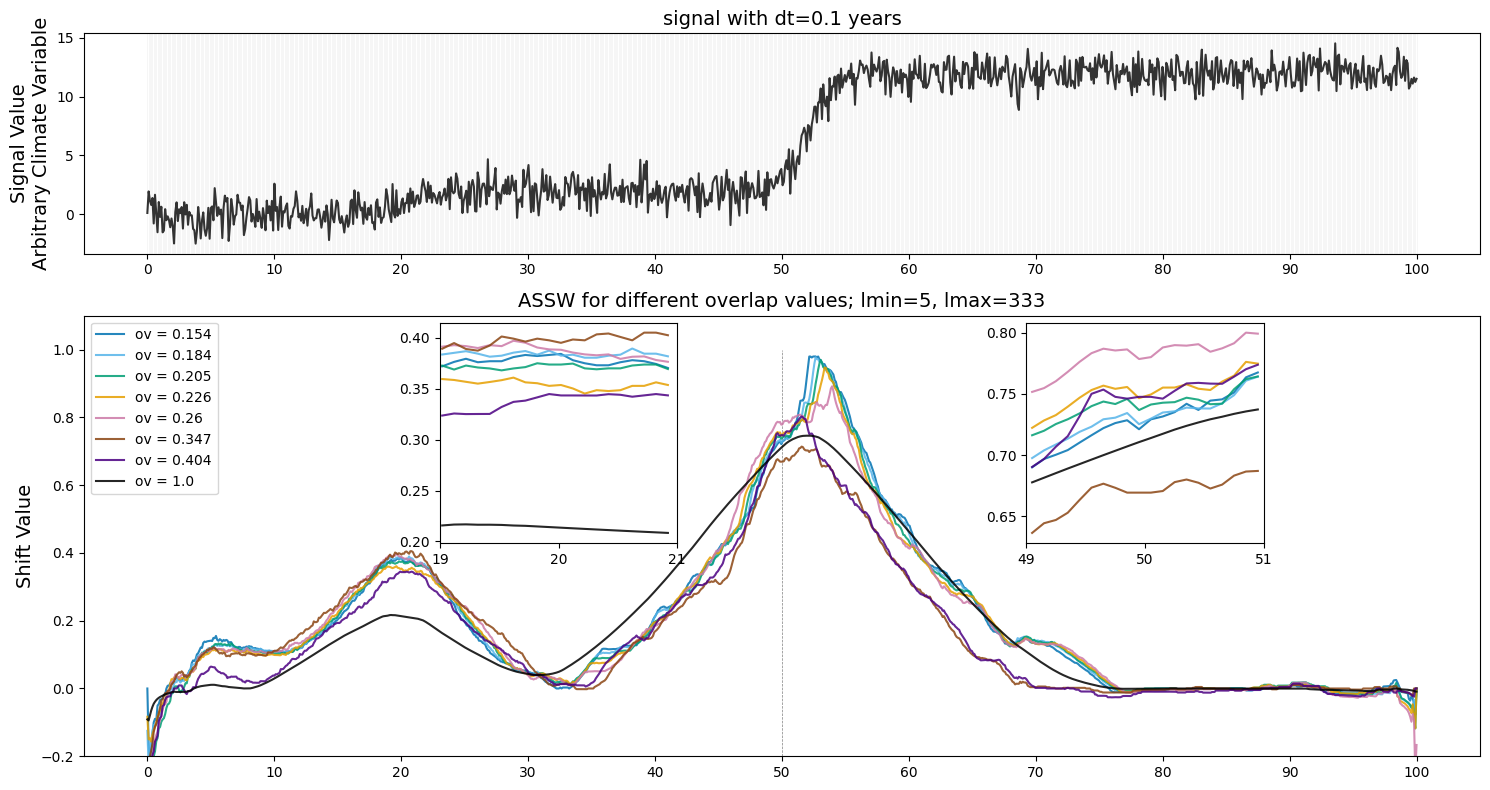

In [224]:
import toad 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt

from toad.shifts.methods.asdetect import ASDETECT
from toad.shifts.methods.asswdetect import ASSWDETECT
from toad.shifts.methods.asswdetect_double import ASSWDETECT as ASSWDETECT_DOUBLE
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def shift(mag, t, t0):
    return mag * (1/(1 + np.exp(-(t-t0))))

dt = 0.1
Tmax = 100 # years
nT = int(Tmax/dt) # number of gridpoints in time
overlap = ov_arr[low_markers_ix]
overlap = np.append(overlap, 1.0)
print(f"{overlap=}")
lmin, lmax = 5, nT//3

# Use distinct, colorblind-friendly colors
colors = [
    "#0072B2", # dark blue
    "#56B4E9", # blue
    "#009E73", # green
    "#E69F00", # orange
    "#CC79A7", # purple
    "#8B4513", # saddle brown (distinct from orange)
    "#4B0082", # indigo (distinct from purple)
    "#000000", # black
]
linewidth = 1.5

# SIGNAL GENERATION =======================================================
noise = np.random.normal(size=nT)
time = np.linspace(0,Tmax, nT)

signal = (noise 
            + shift(10, time, 52)
            + shift(2,time,20)   
        )

# PLOT: SIGNAL ============================================================
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, signal, color="#333333")
for t in time:
    ax1.axvline(t, color='grey', alpha=0.1, lw=0.5, zorder=-1)
ax1.set_title(f'signal with dt={dt} years', fontsize=14)
ax1.set_ylabel('Signal Value\nArbitrary Climate Variable', fontsize=14)

# PLOT: Sliding Window ==================================================
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.vlines(x=Tmax//2, ymin=-0.2, ymax=1, color='grey', linestyles='--', lw=0.5)
for i, ov in enumerate(overlap):
    color = colors[i % len(colors)]
    detector = ASSWDETECT(
        lmin=lmin,
        lmax=lmax,
        overlap=ov
    )
    dts = detector.fit_predict(
        signal,
        time,
    )
    ax2.plot(time, dts, label=f'ov = {round(ov,3)}', alpha=0.85, color=color, linewidth=linewidth)

# INLAY PLOT 1: ==========================================================
area_min, area_max = Tmax*0.49, Tmax*0.51
inset_ax = inset_axes(ax2, width="17%", height="50%", bbox_to_anchor=(-0.15, 0, 1, 1), bbox_transform=ax2.transAxes)
center_mask = (time > area_min) & (time < area_max)
for i, ov in enumerate(overlap):
    color = colors[i % len(colors)]
    detector = ASSWDETECT(
        lmin=lmin,
        lmax=lmax,
        overlap=ov
    )
    dts = detector.fit_predict(
        signal,
        time,
    )
    inset_ax.plot(time[center_mask], dts[center_mask], alpha=0.85, color=color, linewidth=linewidth)
inset_ax.set_title("")
inset_ax.set_xlim(area_min, area_max)
inset_ax.set_xticks(np.arange(np.ceil(area_min), np.floor(area_max)+1, 1))

# INLAY PLOT 2: ==========================================================
area_min, area_max = Tmax*0.19, Tmax*0.21
inset_ax = inset_axes(ax2, width="17%", height="50%", bbox_to_anchor=(-0.57, 0, 1, 1), bbox_transform=ax2.transAxes)
center_mask = (time > area_min) & (time < area_max)
for i, ov in enumerate(overlap):
    color = colors[i % len(colors)]
    detector = ASSWDETECT(
        lmin=lmin,
        lmax=lmax,
        overlap=ov
    )
    dts = detector.fit_predict(
        signal,
        time,
    )
    inset_ax.plot(time[center_mask], dts[center_mask], alpha=0.85, color=color, linewidth=linewidth)
inset_ax.set_title("")
inset_ax.set_xlim(area_min, area_max)
inset_ax.set_xticks(np.arange(np.ceil(area_min), np.floor(area_max)+1, 1))

ax2.set_xticks(np.arange(0, Tmax+1, 10))
ax2.set_ylim(-0.2, 1.1)
ax2.set_title(f'ASSW for different overlap values; lmin={lmin}, lmax={lmax}', fontsize=14)
ax2.legend(loc='upper left')
ax2.set_ylabel('Shift Value', fontsize=14)

# =======================================================================
plt.tight_layout()
plt.savefig("data_time/ASSW_overlap_variation.png", dpi=200)
plt.show()

## Heatmaps

In [204]:
ov_optimal = ov_arr[low_markers_ix]
ov_optimal = np.append(ov_optimal, 1.0)

Tmin = 50
Tmax = 1000 # years
print(ov_optimal)

# make space for histograms
hist_arr = np.full((len(ov_optimal), Tmax, Tmax+1), -1)
for i, overlap in enumerate(ov_optimal):
    print(f'Calculating histogram for overlap={overlap:.3f} ...')
    hist_arr[i] = make_hist(Tmin, Tmax, ASSWDETECT(overlap=overlap))

[0.154 0.184 0.205 0.226 0.26  0.347 0.404 1.   ]
Calculating histogram for overlap=0.154 ...
Calculating histogram for overlap=0.184 ...
Calculating histogram for overlap=0.205 ...
Calculating histogram for overlap=0.226 ...
Calculating histogram for overlap=0.260 ...
Calculating histogram for overlap=0.347 ...
Calculating histogram for overlap=0.404 ...
Calculating histogram for overlap=1.000 ...


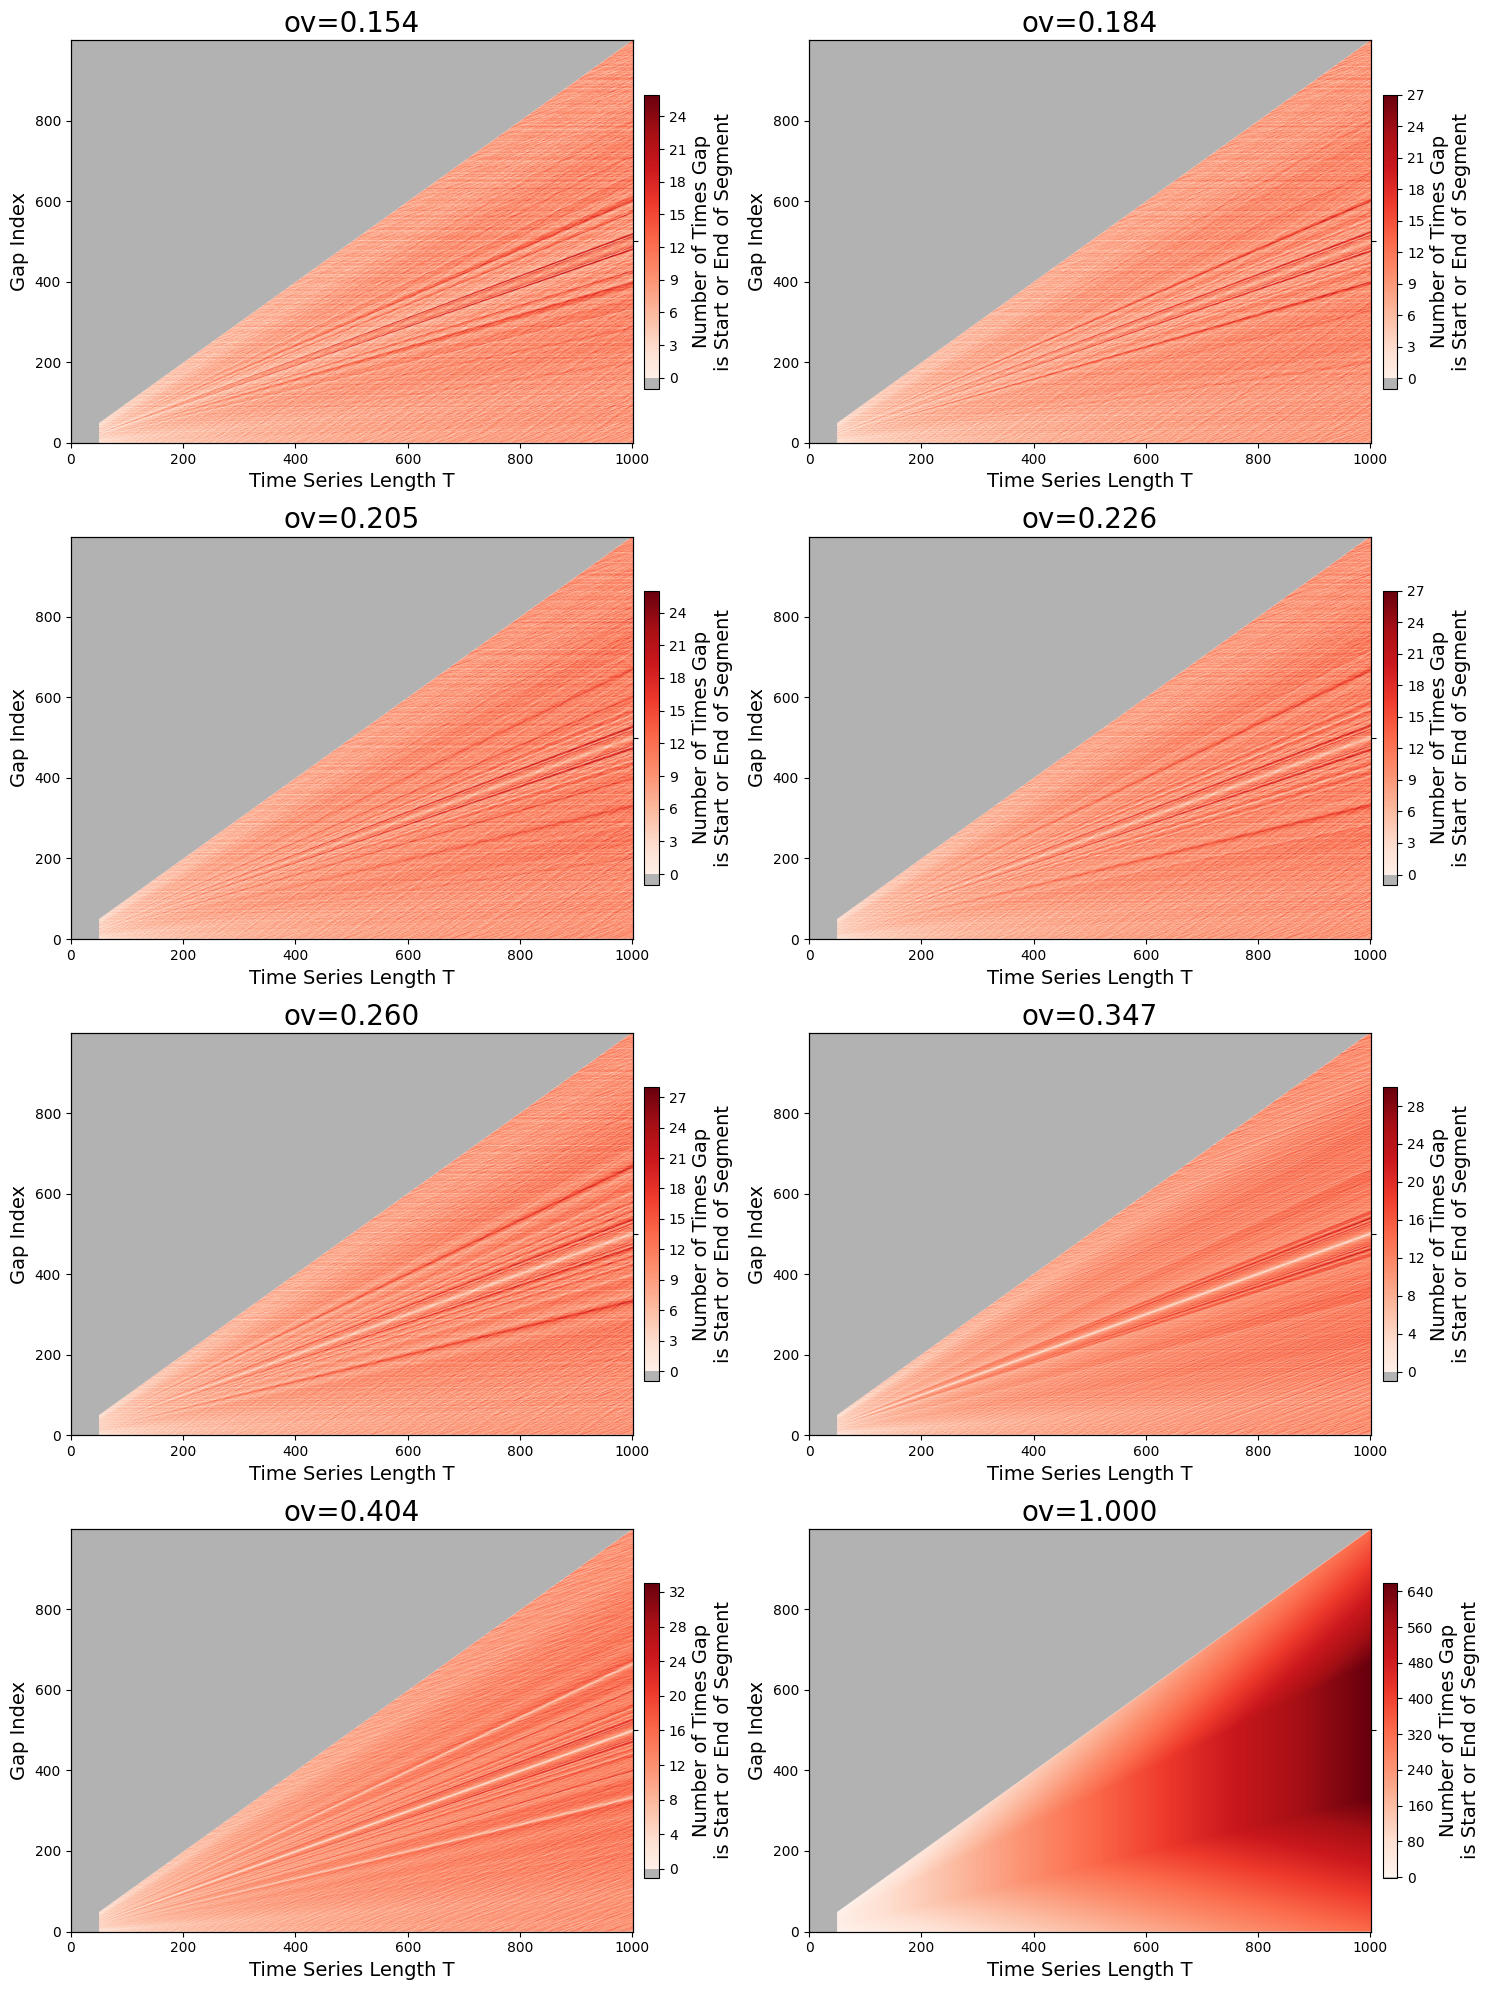

In [212]:
row_num = 4
col_num = 2
fig, axes = plt.subplots(row_num, col_num, figsize=(15, 20))

titles = []
for overlap in ov_optimal:
    titles.append(f"ov={overlap:.3f}")


axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= len(ov_optimal):
        ax.axis('off')
        continue
    plot_hist(hist_arr[i], ax, titles[i])

plt.tight_layout()
plt.savefig('data_time/ASSWDETECT/filename.png', dpi=200)
plt.show()